In [1]:
import os

import numpy as np
#import opencv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
#from torchsummary import summary
from tqdm import tqdm

In [2]:
data_path = r'/kaggle/input/labeled-chest-xray-images/chest_xray'

In [3]:
class_name = ['NORMAL', 'PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [4]:
print("Number of training images in Normal {}".format(len(files_list_normal_train)))
print("Number of training images in Pneumonia {}".format(len(files_list_pneu_train)))
print("Number of test images in Normal {}".format(len(files_list_normal_test)))
print("Number of test images in Pneumonia {}".format(len(files_list_pneu_test)))

Number of training images in Normal 1349
Number of training images in Pneumonia 3883
Number of test images in Normal 234
Number of test images in Pneumonia 390


(1600, 1790)


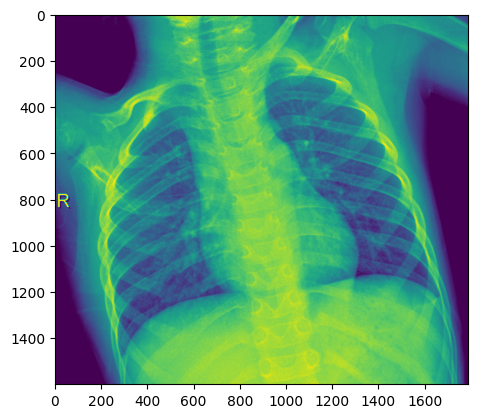

In [5]:
rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = data_path +'/train/NORMAL/'+ files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(800, 1352)


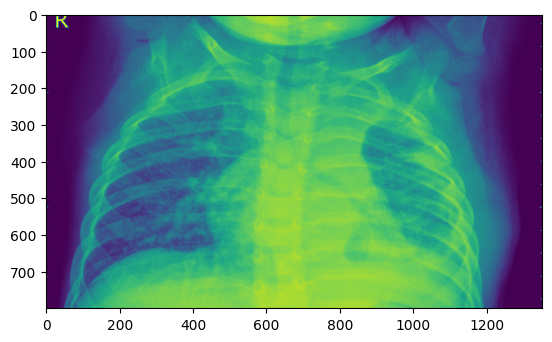

In [6]:
rand_img_no = np.random.randint(0, len(files_list_pneu_train))
img = data_path +'/train/PNEUMONIA/'+ files_list_pneu_train[rand_img_no]
print(plt.imread(img).shape)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)


train_loader =DataLoader(train_data,
                         batch_size= 16,
                         shuffle= True,
                         pin_memory= True)

test_loader = DataLoader(test_data,
                         batch_size= 1,
                         shuffle= False,
                         pin_memory= True)


class_names = train_data.classes

print(class_names)
print(f'Number of train images : {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images : 5232
Number of test images: 624


In [8]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         #input block
#         self.conblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),
#                       padding=0, bias=False),
#                       nn.ReLU(),
#         )
#         self.pool11 = nn.MaxPool2d(2,2)

#         #convolution block
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
#             nn.ReLU(),
#         )

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
        padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(4)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
        padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(16)
        )
        # TRANSITION BLOCK
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #nn.BatchNorm2d(10),
        nn.ReLU()
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        )
        self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        #nn.BatchNorm2d(32),
        nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(16),
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

model = Net().to(device)

Available processor cuda


In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        #get data
        data, target = data.to(device), target.to(device)

        #intialization of gradient
        optimizer.zero_grad()

        # prediction on data
        y_pred =model(data)

        #calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        #backpropagation
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim = True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx} accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss:{:.4f}, accuracy:{}/{}({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100.*correct / len(test_loader.dataset)))
    test_acc.append(100. * correct/len(test_loader.dataset))

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print('EPOCH:', epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


loss=0.6931523084640503 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:59<00:00,  2.74it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 1


loss=0.693149209022522 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.90it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 2


loss=0.693149983882904 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:24<00:00,  3.88it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 3


loss=0.6931478977203369 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.90it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 4


loss=0.693151593208313 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.93it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 5


loss=0.6931469440460205 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.94it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 6


loss=0.6931465268135071 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.89it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 7


loss=0.693147599697113 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.92it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 8


loss=0.6931501626968384 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.90it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 9


loss=0.6931478381156921 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.91it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 10


loss=0.6931489109992981 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:23<00:00,  3.93it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 11


loss=0.6931488513946533 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:23<00:00,  3.91it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 12


loss=0.6931484341621399 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:23<00:00,  3.90it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 13


loss=0.6931491494178772 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:24<00:00,  3.89it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 14


loss=0.6931479573249817 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:23<00:00,  3.90it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)



Text(0.5, 1.0, 'Test Accuracy')

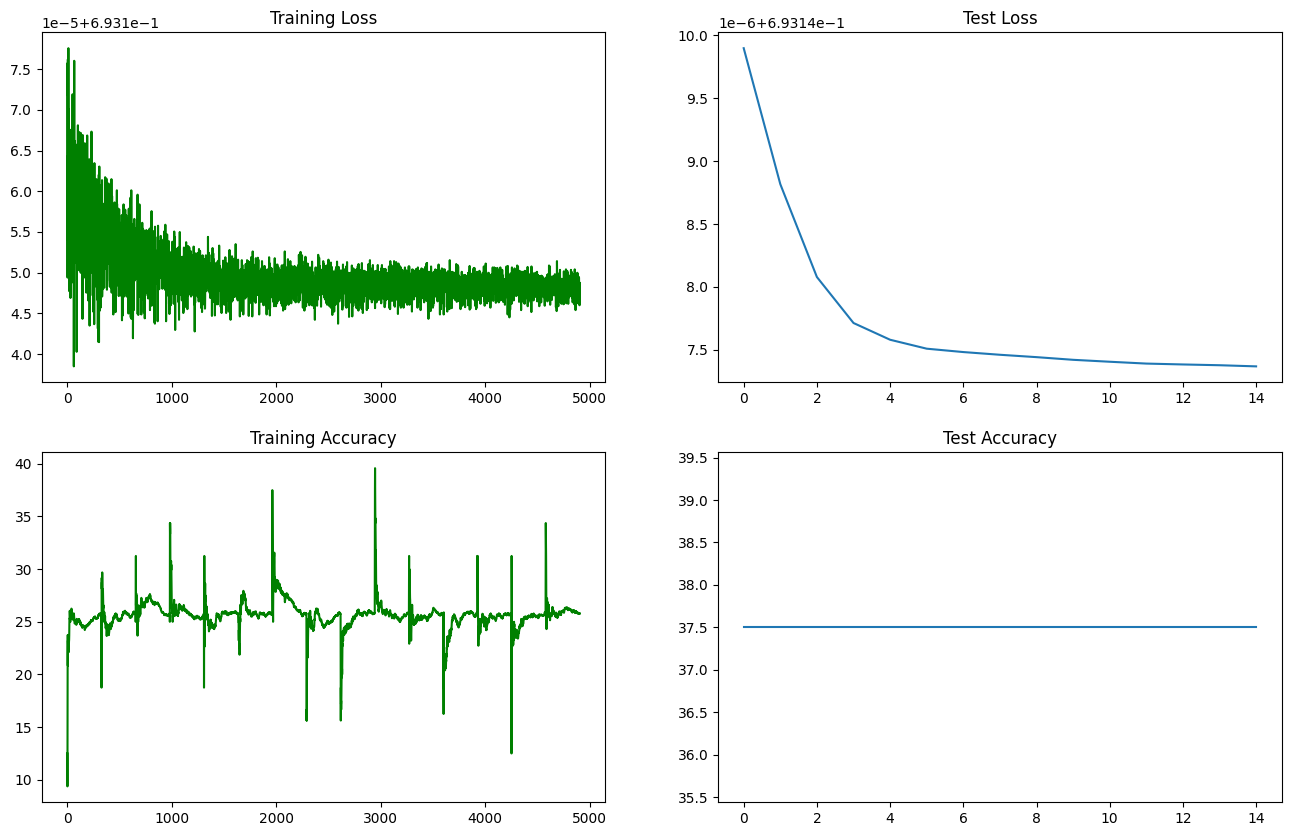

In [13]:
train_losses1 =  [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 =  [i for i in test_acc]


fig, axs = plt.subplots(2,2, figsize= (16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

### 2nd variation of model

Adding more data augmentation to help improve model


In [14]:
train_transform2 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ])
test_transform2 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ])

In [15]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform2)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform2)


train_loader2 =DataLoader(train_data,
                         batch_size= 16,
                         shuffle= True,
                         pin_memory= True)

test_loader2 = DataLoader(test_data,
                         batch_size= 1,
                         shuffle= False,
                         pin_memory= True)


class_names = train_data.classes

print(class_names)
print(f'Number of train images : {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images : 5232
Number of test images: 624


In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print('EPOCH:', epoch)
    train(model, device, train_loader2, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader2)

EPOCH: 0


loss=0.6931496262550354 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:39<00:00,  3.30it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 1


loss=0.6931477189064026 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:37<00:00,  3.36it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 2


loss=0.6931466460227966 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:37<00:00,  3.34it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 3


loss=0.6931481957435608 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:37<00:00,  3.37it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 4


loss=0.6931490898132324 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 5


loss=0.6931450963020325 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:36<00:00,  3.37it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 6


loss=0.6931472420692444 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:38<00:00,  3.33it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 7


loss=0.6931476593017578 batch_id=326 accuracy=25.86: 100%|██████████| 327/327 [01:38<00:00,  3.33it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 8


loss=0.693147599697113 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:37<00:00,  3.36it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 9


loss=0.6931498646736145 batch_id=326 accuracy=25.82: 100%|██████████| 327/327 [01:38<00:00,  3.32it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 10


loss=0.6931475400924683 batch_id=326 accuracy=25.86: 100%|██████████| 327/327 [01:39<00:00,  3.29it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 11


loss=0.6931486129760742 batch_id=326 accuracy=25.86: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 12


loss=0.693148136138916 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 13


loss=0.6931477785110474 batch_id=326 accuracy=25.84: 100%|██████████| 327/327 [01:38<00:00,  3.33it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 14


loss=0.6931466460227966 batch_id=326 accuracy=25.90: 100%|██████████| 327/327 [01:38<00:00,  3.32it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)



Text(0.5, 1.0, 'Test Accuracy')

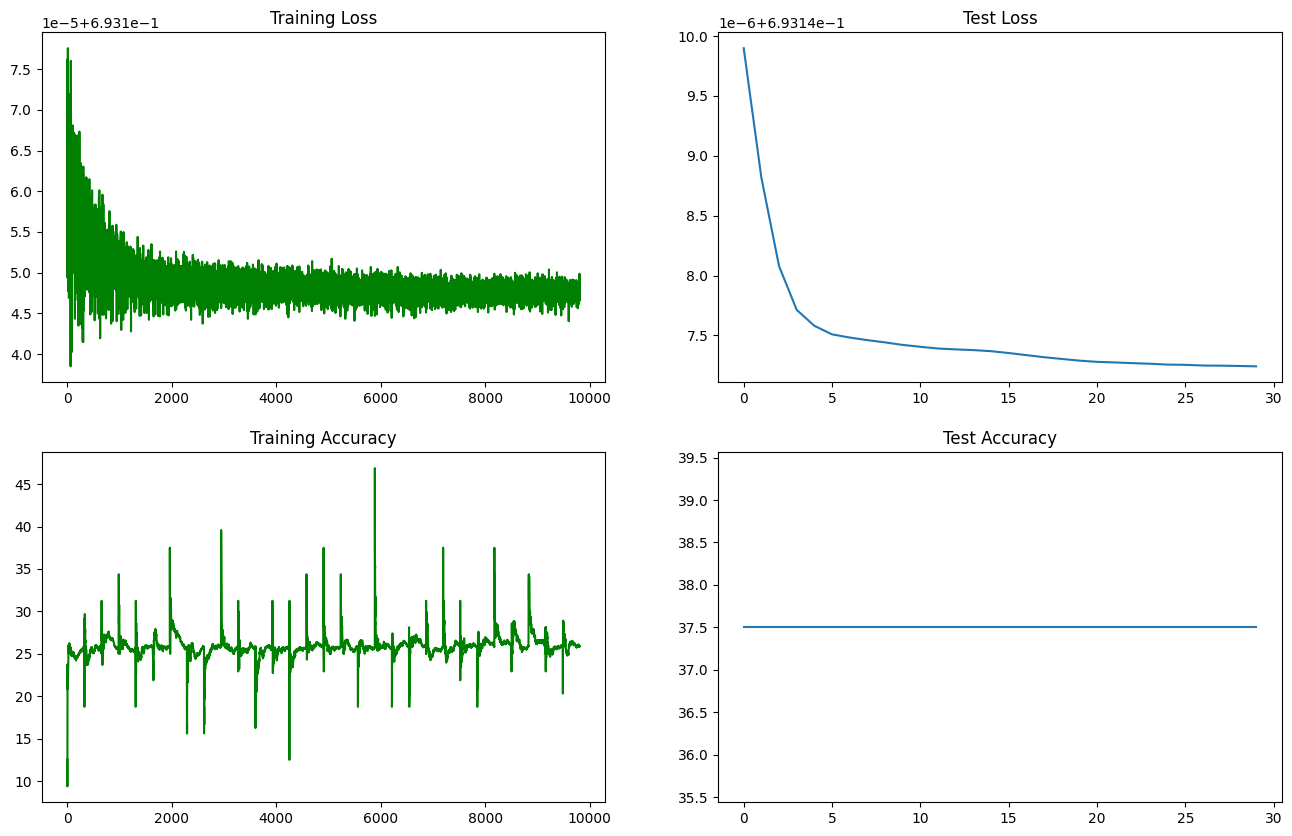

In [17]:
train_losses2 =  [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc2 = [i for i in train_acc]
test_losses2 = [i for i in test_losses]
test_acc2 =  [i for i in test_acc]


fig, axs = plt.subplots(2,2, figsize= (16,10))
axs[0, 0].plot(train_losses2,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc2,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc2)
axs[1, 1].set_title("Test Accuracy")

### 3rd Model variation

Introduction of batch normalization

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
        padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
        padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        )
        self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32)
        )
        self.convblock9 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(10)
        )
        self.convblock10 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(14)
        )
        self.convblock11 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [19]:
model2 = Net().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print('EPOCH:', epoch)
    train(model, device, train_loader2, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader2)

EPOCH: 0


loss=0.693146824836731 batch_id=326 accuracy=25.78: 100%|██████████| 327/327 [01:39<00:00,  3.30it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 1


loss=0.693148136138916 batch_id=326 accuracy=25.88: 100%|██████████| 327/327 [01:39<00:00,  3.28it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 2


loss=0.6931466460227966 batch_id=326 accuracy=25.82: 100%|██████████| 327/327 [01:40<00:00,  3.27it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 3


loss=0.6931460499763489 batch_id=326 accuracy=25.86: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 4


loss=0.6931468844413757 batch_id=326 accuracy=25.90: 100%|██████████| 327/327 [01:40<00:00,  3.24it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 5


loss=0.6931475400924683 batch_id=326 accuracy=25.82: 100%|██████████| 327/327 [01:38<00:00,  3.33it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 6


loss=0.6931480169296265 batch_id=326 accuracy=25.84: 100%|██████████| 327/327 [01:38<00:00,  3.33it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 7


loss=0.6931476593017578 batch_id=326 accuracy=25.80: 100%|██████████| 327/327 [01:40<00:00,  3.27it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 8


loss=0.6931479573249817 batch_id=326 accuracy=25.84: 100%|██████████| 327/327 [01:39<00:00,  3.29it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 9


loss=0.6931478381156921 batch_id=326 accuracy=25.82: 100%|██████████| 327/327 [01:40<00:00,  3.25it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 10


loss=0.6931477189064026 batch_id=326 accuracy=25.86: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 11


loss=0.6931477189064026 batch_id=326 accuracy=25.84: 100%|██████████| 327/327 [01:38<00:00,  3.31it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 12


loss=0.6931478977203369 batch_id=326 accuracy=25.84: 100%|██████████| 327/327 [01:41<00:00,  3.22it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 13


loss=0.6931475400924683 batch_id=326 accuracy=25.86: 100%|██████████| 327/327 [01:40<00:00,  3.24it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)

EPOCH: 14


loss=0.6931473612785339 batch_id=326 accuracy=25.90: 100%|██████████| 327/327 [01:41<00:00,  3.24it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6931, accuracy:234/624(37.50%)



Text(0.5, 1.0, 'Test Accuracy')

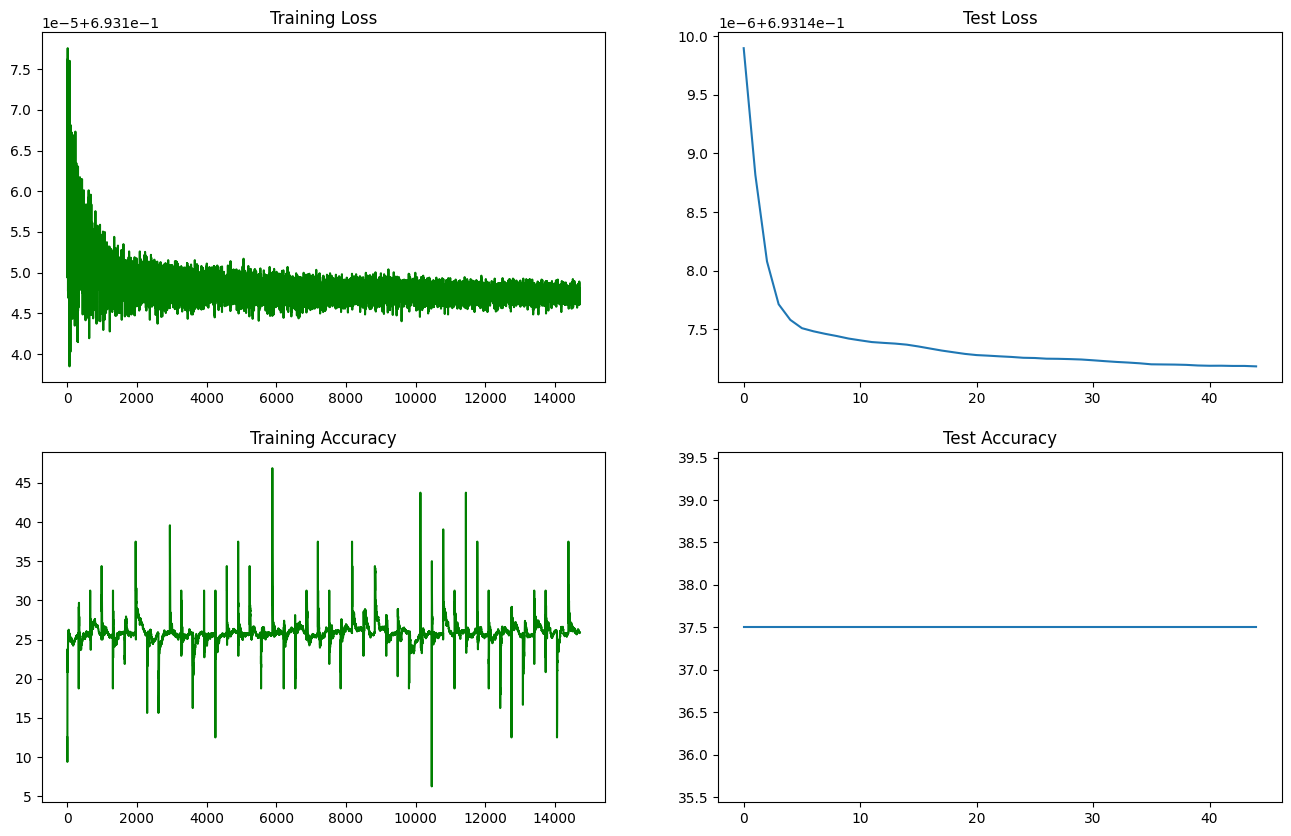

In [20]:
train_losses3 =  [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc3 = [i for i in train_acc]
test_losses3 = [i for i in test_losses]
test_acc3 =  [i for i in test_acc]


fig, axs = plt.subplots(2,2, figsize= (16,10))
axs[0, 0].plot(train_losses3,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc3,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses3)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc3)
axs[1, 1].set_title("Test Accuracy")

### 4th model variation

Regularization

In [21]:
from tqdm import tqdm
import torch.nn.functional as F

def train2(model, device, train_loader, optimizer, epoch, lambda_l1=0.0):
    model.train()  # Set the model to training mode
    pbar = tqdm(train_loader)  # Progress bar

    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Move data and target to the appropriate device (CPU/GPU)
        data, target = data.to(device), target.to(device)

        # Initialize the gradients
        optimizer.zero_grad()

        # Prediction on data
        y_pred = model(data)

        # Calculate the loss
        loss = F.nll_loss(y_pred, target)

        # Add L1 regularization if lambda_l1 > 0
        if lambda_l1 > 0:
            l1 = 0
            for p in model.parameters():
                l1 += p.abs().sum()
            loss += lambda_l1 * l1

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Prediction and accuracy
        pred = y_pred.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        # Update progress bar
        accuracy = 100 * correct / processed
        pbar.set_description(desc=f'loss={loss.item():.4f} batch_id={batch_idx} accuracy={accuracy:.2f}')

        # Log metrics
        train_losses.append(loss.item())
        train_acc.append(accuracy)


In [22]:
model3 = Net().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print('EPOCH:', epoch)
    train2(model3, device, train_loader2, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model3, device, test_loader2)

EPOCH: 0


loss=0.6413 batch_id=326 accuracy=57.82: 100%|██████████| 327/327 [01:42<00:00,  3.19it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6886, accuracy:334/624(53.53%)

EPOCH: 1


loss=0.6582 batch_id=326 accuracy=57.76: 100%|██████████| 327/327 [01:40<00:00,  3.25it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6910, accuracy:335/624(53.69%)

EPOCH: 2


loss=0.7148 batch_id=326 accuracy=58.05: 100%|██████████| 327/327 [01:41<00:00,  3.22it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6892, accuracy:335/624(53.69%)

EPOCH: 3


loss=0.6234 batch_id=326 accuracy=57.49: 100%|██████████| 327/327 [01:41<00:00,  3.23it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6898, accuracy:339/624(54.33%)

EPOCH: 4


loss=0.6749 batch_id=326 accuracy=58.24: 100%|██████████| 327/327 [01:43<00:00,  3.15it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6901, accuracy:340/624(54.49%)

EPOCH: 5


loss=0.6571 batch_id=326 accuracy=58.37: 100%|██████████| 327/327 [01:40<00:00,  3.25it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6884, accuracy:341/624(54.65%)

EPOCH: 6


loss=0.6734 batch_id=326 accuracy=58.26: 100%|██████████| 327/327 [01:41<00:00,  3.21it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6893, accuracy:341/624(54.65%)

EPOCH: 7


loss=0.6478 batch_id=326 accuracy=58.72: 100%|██████████| 327/327 [01:42<00:00,  3.18it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6899, accuracy:338/624(54.17%)

EPOCH: 8


loss=0.6576 batch_id=326 accuracy=59.65: 100%|██████████| 327/327 [01:43<00:00,  3.17it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6892, accuracy:347/624(55.61%)

EPOCH: 9


loss=0.6595 batch_id=326 accuracy=58.28: 100%|██████████| 327/327 [01:42<00:00,  3.20it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6896, accuracy:340/624(54.49%)

EPOCH: 10


loss=0.7150 batch_id=326 accuracy=60.00: 100%|██████████| 327/327 [01:41<00:00,  3.21it/s]


current Learning Rate:  0.005

Test set: Average loss:0.6896, accuracy:336/624(53.85%)

EPOCH: 11


loss=0.6762 batch_id=326 accuracy=58.81: 100%|██████████| 327/327 [01:41<00:00,  3.23it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6911, accuracy:333/624(53.37%)

EPOCH: 12


loss=0.6872 batch_id=326 accuracy=58.89: 100%|██████████| 327/327 [01:40<00:00,  3.26it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6898, accuracy:339/624(54.33%)

EPOCH: 13


loss=0.6319 batch_id=326 accuracy=58.60: 100%|██████████| 327/327 [01:44<00:00,  3.14it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6884, accuracy:341/624(54.65%)

EPOCH: 14


loss=0.6279 batch_id=326 accuracy=57.99: 100%|██████████| 327/327 [01:41<00:00,  3.24it/s]


current Learning Rate:  0.0025

Test set: Average loss:0.6894, accuracy:337/624(54.01%)



Text(0.5, 1.0, 'Test Accuracy')

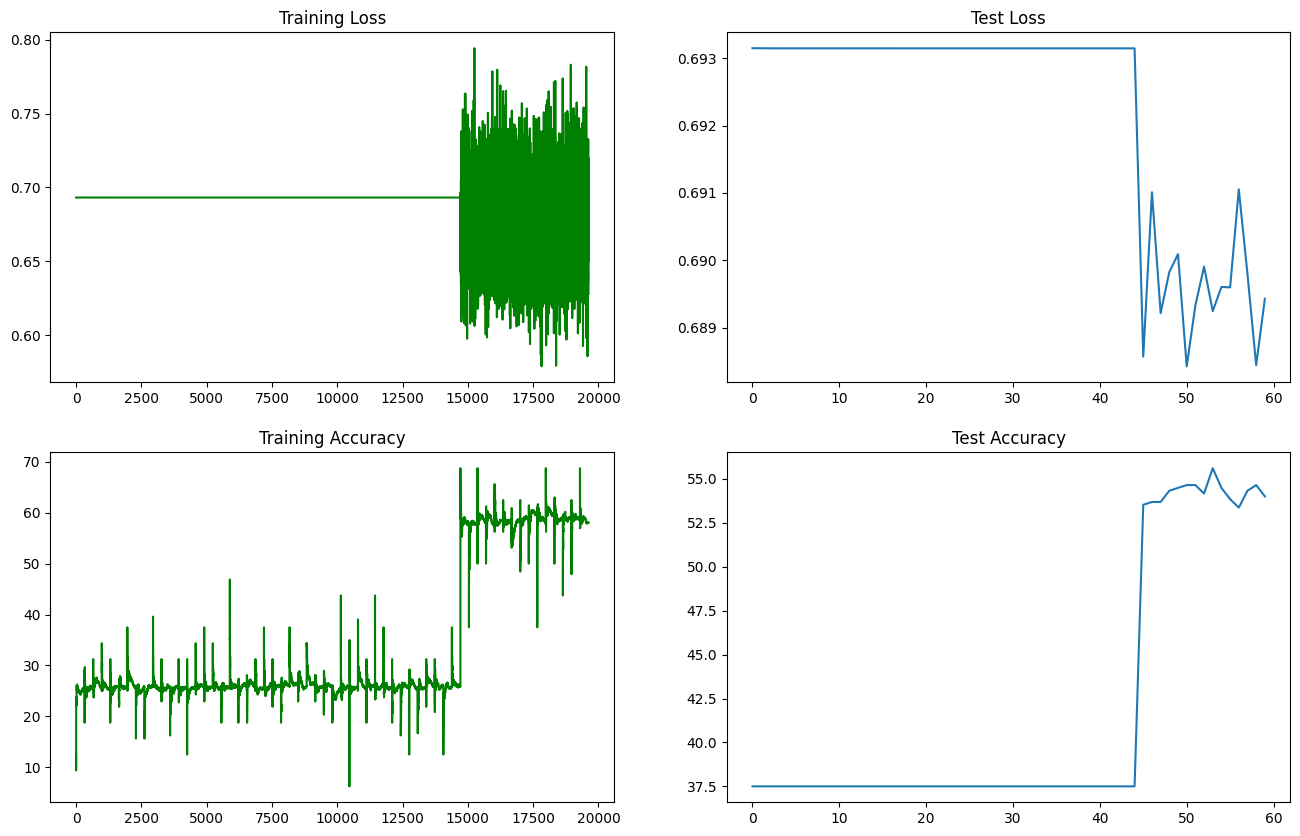

In [23]:
train_losses4 = [float(i) for i in train_losses] 
train_acc4 = [i for i in train_acc]  
test_losses4 = [i for i in test_losses] 
test_acc4 = [i for i in test_acc]  


fig, axs = plt.subplots(2,2, figsize= (16,10))
axs[0, 0].plot(train_losses4,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc4,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses4)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc4)
axs[1, 1].set_title("Test Accuracy")